In [1]:
# Model design
import agentpy as ap
import random
import numpy as np

# Needed for running models
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import IPython
import numpy as np
from scipy.ndimage import label
from scipy.ndimage import label, binary_dilation

# Set seed
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [2]:

'''
Modified from Foramitti, J. (2021). Forest fire model example (AgentPy). Retrieved from https://agentpy.readthedocs.io/en/latest/agentpy_forest_fire.html


Rules of the system:
1. A burning tree becomes an empty site
2. A green tree becomes burning if at least one of its neighbours is burning
3. At an empty site, a tree grows with the probability p
4. A tree without a burning neighbour becomes a burning tree at any time step with the probability f ('lightning')
'''

"\nModified from Foramitti, J. (2021). Forest fire model example (AgentPy). Retrieved from https://agentpy.readthedocs.io/en/latest/agentpy_forest_fire.html\n\n\nRules of the system:\n1. A burning tree becomes an empty site\n2. A green tree becomes burning if at least one of its neighbours is burning\n3. At an empty site, a tree grows with the probability p\n4. A tree without a burning neighbour becomes a burning tree at any time step with the probability f ('lightning')\n"

In [3]:

class ForestModel(ap.Model):

    def setup(self):

        # Create agents (trees)
        n_trees = int(self.p['Tree density'] * (self.p.size**2))
        trees = self.agents = ap.AgentList(self, n_trees)

        # Create grid (forest)
        self.forest = ap.Grid(self, [self.p.size]*2, track_empty=True)
        self.forest.add_agents(trees, random=True, empty=True)

        # Initiate a dynamic variable for all trees
        # Condition 0: Alive, 1: Burning, 2: Empty
        self.agents.condition = 0        
        # Amount of lightning
        self.f = self.p['probability of lightning']

        # Ratio between f and p
        self.p_over_f = self.p['p_over_f']

        # Assign value to p
        self.growth = self.f * self.p_over_f

        self.tree_counts = []  # Initialize list to store number of trees
        #we could also maybe delete these:
        self.cluster_counts = []
        self.cluster_size = []
        #until here
        #added
        self.cluster_size_notime = []
        self.cluster_counts_notime = []

    #maybe we can actually delete this
    def count_fire_clusters(self):
        # Build 2D array of conditions
        grid_state = np.full(self.forest.shape, 2,dtype=np.int8)
        for agent in self.agents:
            x, y = self.forest.positions[agent]
            grid_state[x, y] = int(agent.condition)

        # Mask the target state (1 = burning, 0 = tree, etc.)
        mask = (grid_state == 1)

        # Identify clusters of healthy trees (0)
        structure = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=int)  # 4-connected
        labeled, num = label(mask, structure=structure)

        if num == 0:
            return 0, []
        counts = np.bincount(labeled.ravel())[1:]
        return num, counts
    #added
    def count_connected_to_healthy(self):
        # Build 2D array of conditions
        grid_state = np.full(self.forest.shape, 2,dtype=np.int8)
        for agent in self.agents:
            x, y = self.forest.positions[agent]
            grid_state[x, y] = int(agent.condition)

        # Mask the target states (tree, ignited)
        healthy_mask = (grid_state == 0)
        fire_mask = (grid_state == 3)

        # Identify clusters of healthy trees (0)
        structure = np.array([[0,1,0],[1,1,1],[0,1,0]], dtype=bool)  # 4-connected
        labeled, num = label(healthy_mask, structure=structure)

        if num == 0:
            return 0, []
        # Dilate fire_mask to mark all its 4-neighbors
        dilated_fire = binary_dilation(fire_mask, structure=structure)
        touching_labels = np.unique(labeled[dilated_fire & healthy_mask])
        touching_labels = touching_labels[touching_labels > 0]  # remove background 0

        if len(touching_labels) == 0:
            return 0, []
        counts = np.bincount(labeled.ravel())[1:]
        connected_counts = counts[np.array(touching_labels) - 1]
        total_connected_trees = int(np.sum(connected_counts))
        return total_connected_trees, connected_counts.tolist()



    def step(self):

        # Select burning trees
        burning_trees = self.agents.select(self.agents.condition == 1)

        # Select empty lots
        no_trees = self.agents.select(self.agents.condition == 2)

        # Select healthy trees
        healthy_trees = self.agents.select(self.agents.condition == 0)

        #added
        ignited_trees = self.agents.select(self.agents.condition == 3)

        # Add lighting
        for tree in healthy_trees:
            if random.random() < self.f:
                #tree.condition = 1 #replace both
                #added
                tree.condition = 3
        #added:
        for tree in ignited_trees:
            for neighbor in self.forest.neighbors(tree):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            
        # Spread fire
        for tree in burning_trees:
            for neighbor in self.forest.neighbors(tree):
                if neighbor.condition == 0:
                    neighbor.condition = 1 # Neighbor starts burning
            tree.condition = 2 # Tree burns out


        for tree in no_trees:
            if random.random() < self.growth:
                tree.condition = 0

        nr_trees = len(self.agents.select(self.agents.condition == 0))
        self.tree_counts.append(nr_trees)
        
        #store clusters
        #we could maybe delete this:
        num_clusters, cluster_size = self.count_fire_clusters()
        self.cluster_counts.append(num_clusters)
        self.cluster_size.append(cluster_size)
        #until here
        #added
        size_every_cluster_without_time, size_clusters_without_time = self.count_connected_to_healthy()
        self.cluster_size_notime.append(size_every_cluster_without_time)
        self.cluster_counts_notime.append(size_clusters_without_time)

        
        #added
        for tree in ignited_trees:
            tree.condition = 2 # Tree burns out

    def end(self):

        # Document a measure at the end of the simulation
        burned_trees = len(self.agents.select(self.agents.condition == 2))
        self.report('Percentage of burned trees',
                    burned_trees / len(self.agents))

In [4]:
# Define parameters

parameters_animation = {
    'Tree density': 1, # Percentage of grid covered by trees
    'size': 50, # Height and length of the grid
    'steps': 200,
    'probability of lightning': 0.0001,
    'p_over_f': 100 # assign a ratio to ensure that f << p
}

parameters = {
    'Tree density': 1, # Percentage of grid covered by trees
    'size': 200, # Height and length of the grid
    'steps': 2000,
    'probability of lightning': 0.0001,
    'p_over_f': 100 # assign a ratio to ensure that f << p
}

In [5]:
# Create single-run animation with custom colors
def animation_plot(model, ax):
    attr_grid = model.forest.attr_grid('condition')
    color_dict = {0:'#7FC97F', 1:'#d62c2c', 2:'#e5e5e5', 3: '#ffb347',None:'#d5e5d5'}
    ap.gridplot(attr_grid, ax=ax, color_dict=color_dict, convert=True)
    ax.set_title(f"Simulation of a forest fire\n"
                 f"Time-step: {model.t}, Trees left: "
                 f"{len(model.agents.select(model.agents.condition == 0))}")
def animation_plot_values(model):
    time_steps = []
    attr_grid = model.forest.attr_grid('condition')
    model.tree_counts.append(len(model.agents.select(model.agents.condition == 0)))
    return time_steps, model.tree_counts


fig, ax = plt.subplots()
model = ForestModel(parameters_animation)
animation = ap.animate(model, fig, ax, animation_plot)
#animation.save('forest_fire_animation.gif', writer='pillow', fps=15)
IPython.display.HTML(animation.to_jshtml(fps=15))


In [6]:
list_lightning = [1e-3, 1e-5, 1e-6]
list_p_over_f  = [100, 1000, 10000]
records = []   # this will hold all rows

for f in list_lightning:
    for p_over_f in list_p_over_f:
        params = parameters.copy()
        params['probability of lightning'] = f
        params['p_over_f '] = p_over_f

        model = ForestModel(params)
        model.run()

        # Tree counts
        for t, trees in enumerate(model.tree_counts):
            records.append({"type": "tree_count",
                            "time": t,
                            "tree_count": trees,
                            "fire_size": np.nan,
                            "f": f,
                            "p_over_f": p_over_f})

        # Fire sizes
        all_clusters = []
        for lst in model.cluster_counts_notime:
            if isinstance(lst, (list, np.ndarray)) and len(lst) > 0:
                all_clusters.extend(lst)
        for s in all_clusters:
            records.append({"type": "fire",
                            "time": np.nan,
                            "tree_count": np.nan,
                            "fire_size": s,
                            "f": f,
                            "p_over_f": p_over_f})

# Convert to DataFrame and save
df = pd.DataFrame.from_records(records)
df.to_csv("forest_fire_results.csv", index=False)
print("data saved to forest_fire_results.csv")

Completed: 2000 steps
Run time: 0:02:54.908257
Simulation finished
Completed: 2000 steps
Run time: 0:03:17.698051
Simulation finished
Completed: 2000 steps
Run time: 0:03:54.281719
Simulation finished
Completed: 2000 steps
Run time: 0:02:40.486794
Simulation finished
Completed: 2000 steps
Run time: 0:02:07.747261
Simulation finished
Completed: 2000 steps
Run time: 0:01:52.359795
Simulation finished
Completed: 2000 steps
Run time: 0:02:03.429738
Simulation finished
Completed: 2000 steps
Run time: 0:02:52.999489
Simulation finished
Completed: 2000 steps
Run time: 0:02:57.197935
Simulation finished
data saved to forest_fire_results.csv


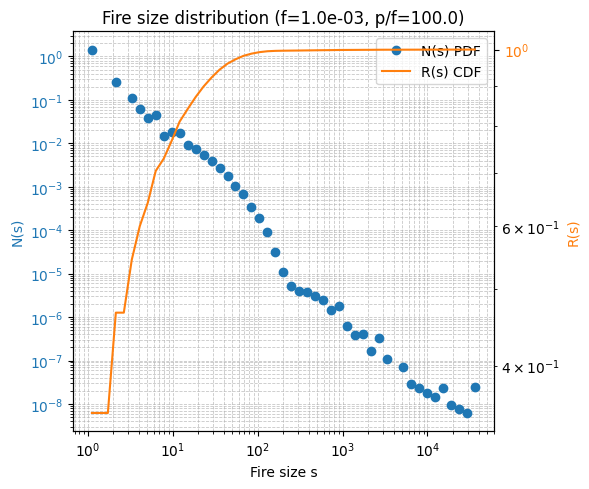

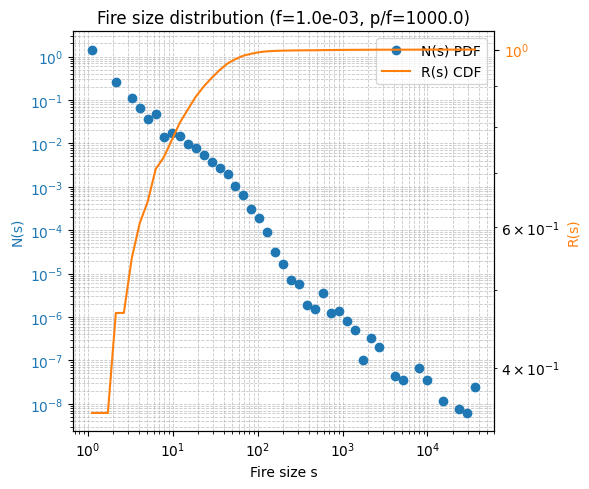

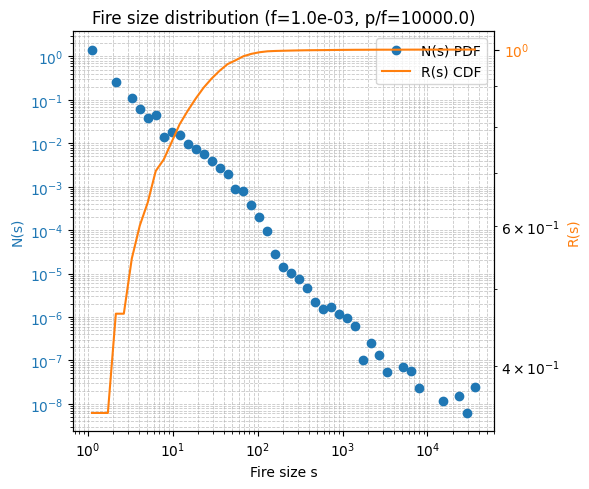

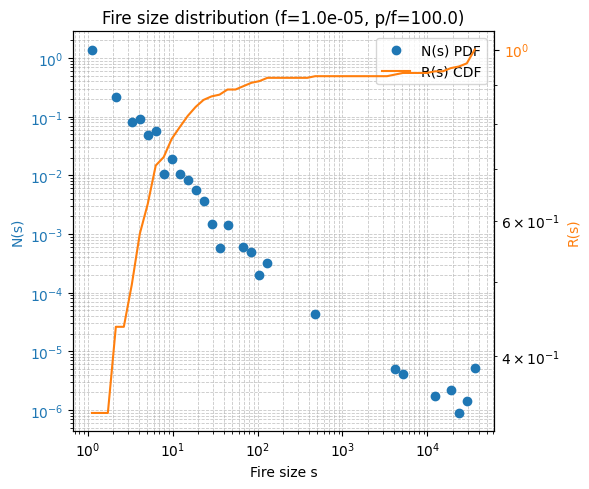

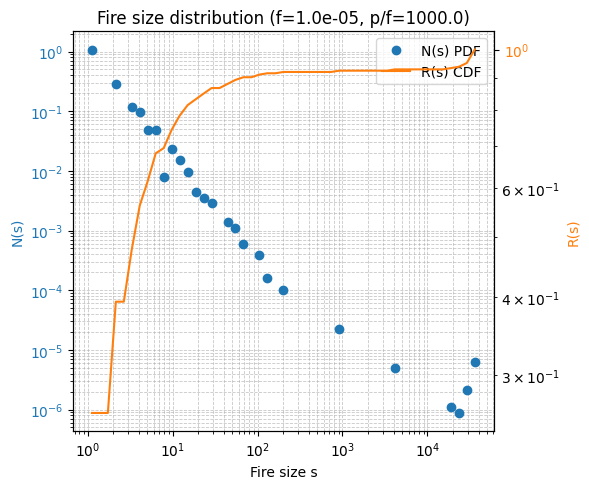

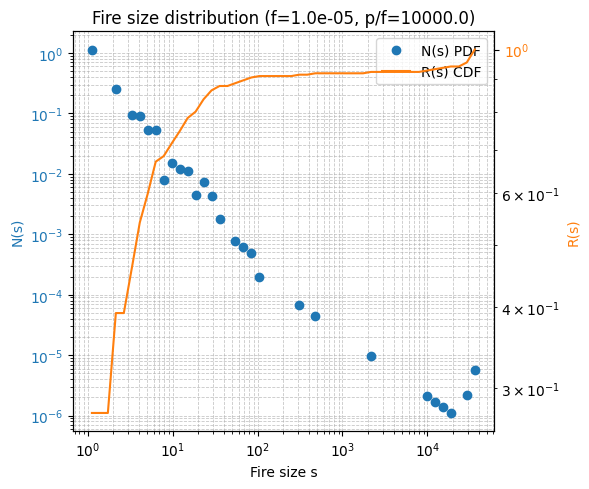

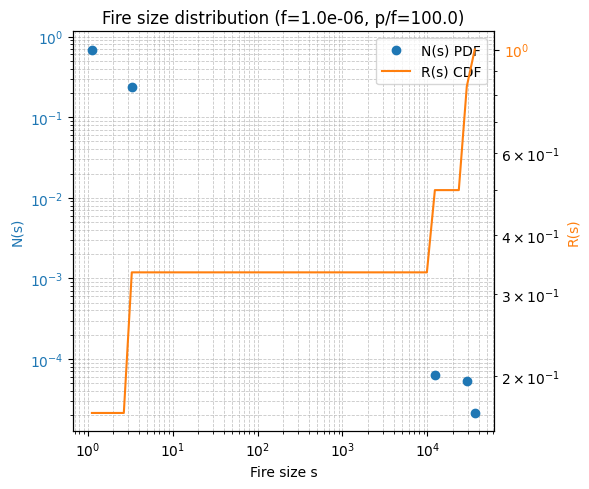

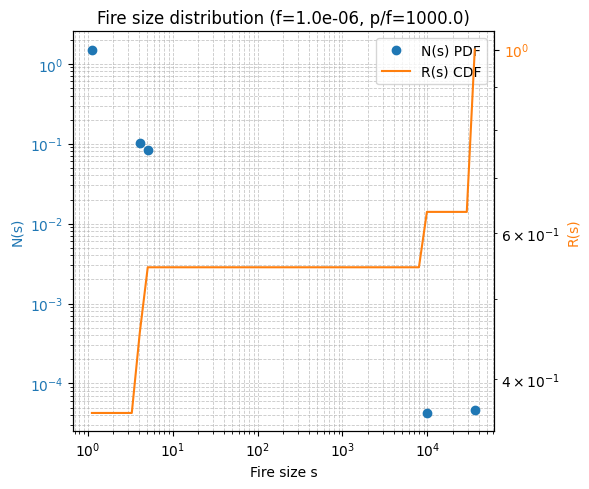

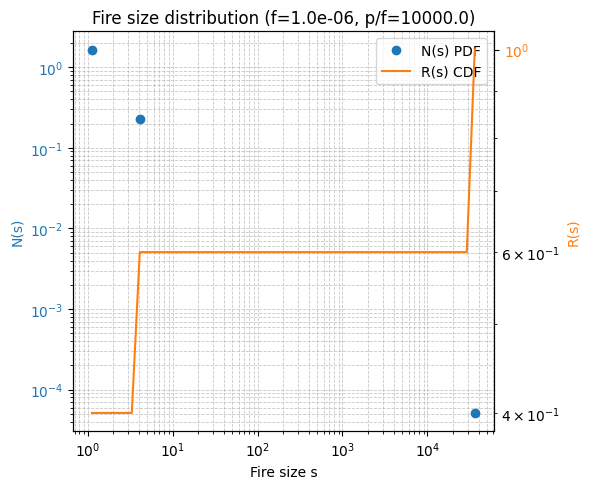

In [9]:
# Load and filter
df = pd.read_csv("forest_fire_results.csv")
df_fires = df[df["type"] == "fire"]
param_sets = df[['f', 'p_over_f']].drop_duplicates()

for _, row in param_sets.iterrows():
    f = row['f']
    p_over_f = row['p_over_f']
    fires = df_fires[
        (df_fires['f'] == f) & 
        (df_fires['p_over_f'] == p_over_f)
    ]['fire_size'].dropna()

    if fires.empty:
        continue

    sizes = np.sort(fires.values)
    n = len(sizes)

    #  PDF: N(s)
    bins = np.logspace(np.log10(1), np.log10(sizes.max() + 1), 50)
    hist, edges = np.histogram(sizes, bins=bins, density=True)
    centers = 0.5 * (edges[:-1] + edges[1:])

    # CDF: R(s)
    R = np.cumsum(hist * np.diff(edges))
    R = R / R.max()  # normalize for convenience

    
    
    fig, ax1 = plt.subplots(figsize=(6, 5))
    # PDF plotting
    ax1.loglog(centers, hist, 'o', label='N(s) PDF', color='C0')
    ax1.set_xlabel("Fire size s")
    ax1.set_ylabel("N(s)", color='C0')
    ax1.tick_params(axis='y', labelcolor='C0')

    # CDF plotting
    ax2 = ax1.twinx()
    ax2.loglog(centers, R, '-', label='R(s) CDF', color='C1')
    ax2.set_ylabel("R(s)", color='C1')
    ax2.tick_params(axis='y', labelcolor='C1')

    plt.title(f"Fire size distribution (f={f:.1e}, p/f={p_over_f})")
    ax1.grid(True, which='both', ls='--', lw=0.6, alpha=0.7)
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best')

    plt.tight_layout()
    plt.show()

In [8]:
L = 200  
df_trees = df[df['type'] == 'tree_count'].copy()

# Compute density
df_trees['density'] = df_trees['tree_count'] / (L**2)

# Sort to ensure correct time order within each parameter set
df_trees = df_trees.sort_values(['f', 'p_over_f', 'time'])



# Merge with average density for reference
avg_density = (
    df_trees.groupby(['f', 'p_over_f'])['density']
    .mean()
    .reset_index(name='avg_density')
)

# Print results
print(avg_density.sort_values(['f', 'p_over_f']))

          f  p_over_f  avg_density
0  0.000001       100     0.135245
1  0.000001      1000     0.128906
2  0.000001     10000     0.120096
3  0.000010       100     0.259629
4  0.000010      1000     0.260446
5  0.000010     10000     0.259111
6  0.001000       100     0.256357
7  0.001000      1000     0.255859
8  0.001000     10000     0.255956
